# Numerical Exercises 07

## Exercise 07.1
In the NSL simulator code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

## Solution

In our molecular dynamics simulation algorithm, the Lennard-Jones potential is computed for all pairs of particles. Since the force is short-ranged, the main contribution typically comes from nearby particles. Therefore, we apply a **spherical cutoff**: if the distance between two particles exceeds a chosen cutoff radius $ r > r_{\text{cut}} $, the potential is neglected.

It is possible to correct the values of the potential energy $ V $ and pressure $ P $ by estimating the missing long-range contribution, assuming that the radial distribution function satisfies $ g(r) \simeq 1 $ in the region $ r > r_{\text{cut}} $.


$$\frac{\langle V_{LJ} \rangle_{tail}}{N} = 2\rho \pi N \int_{r_{cut}}^{+\infty} r^2 v(r)^2 g(r) dr \simeq \frac{8\pi\rho_{LJ} \epsilon}{9r_{cut}^9} - \frac{8\pi\rho_{LJ} \epsilon}{3r_{cut}^3}$$

$$\frac{\langle w_{LJ} \rangle_{tail}}{3N\epsilon} = 32 \pi \rho \left[\frac{1}{9r_{cut}^9} - \frac{1}{6r_{cut}^3} \right] $$

The correction terms defined above have therefore been included in the computation of the pressure and the potential energy.


```c++
void System :: initialize_properties(string path){

    /* ... */

    _vtail = 8. * M_PI * _rho * (1 / (9. * pow(_r_cut, 9)) - 1 / (3 * pow(_r_cut, 3))); // tail correction for potential energy

    /* ... */

    _ptail = 32. * M_PI * _rho * (1 / (9 * pow(_r_cut, 9)) - 1 / (6 * pow(_r_cut, 3))); // tail correction for pressure

    /* ... */
}
```

## Exercise 07.2

Use the NSL simulator code to <span style="color:red">print out **instantaneous** values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo $(N,V,T)$ and Molecular Dynamics $(N,V,E)$ simulations</span> of $M=5\times 10^5$ MC steps or MD time steps (where, for MC, the Metropolis acceptance ratio should be fixed approximately to 50% by changing the value of $dt$ that, in the MC case, represent the amplitude of the step in each direction) in the following thermodynamic conditions:
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r^\star_c = 2.5$, for MD $dt^\star=0.001$)

Equilibration is needed both with MC and with MD. With MD, you will observe that starting from a perfect crystalline configuration the temperature, $T$, will not conserve its value. Explore and find the starting value of $T$ needed to stabilize, after a certain number of time steps (equilibration time), the average value of $T$ on the desired $T^\star$.
<span style="color:red">Perform your MC and MD simulations by re-starting after such equilibration time.</span>

1. <span style="color:red">Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. <span style="color:red">Make pictures of these statistical uncertainties as a function of $L$.</span> What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

## Solution

### Equilibration

Starting from a perfect crystalline configuration, we need to equilibrate the system. To evaluate the equilibration time, i performed a simulation of $5000$ steps and measured the istantaneous values of the potential energy per particle, $U/N$, and the temperature.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit
from scipy.optimize import curve_fit
import warnings
import os

warnings.filterwarnings('ignore')
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'serif'

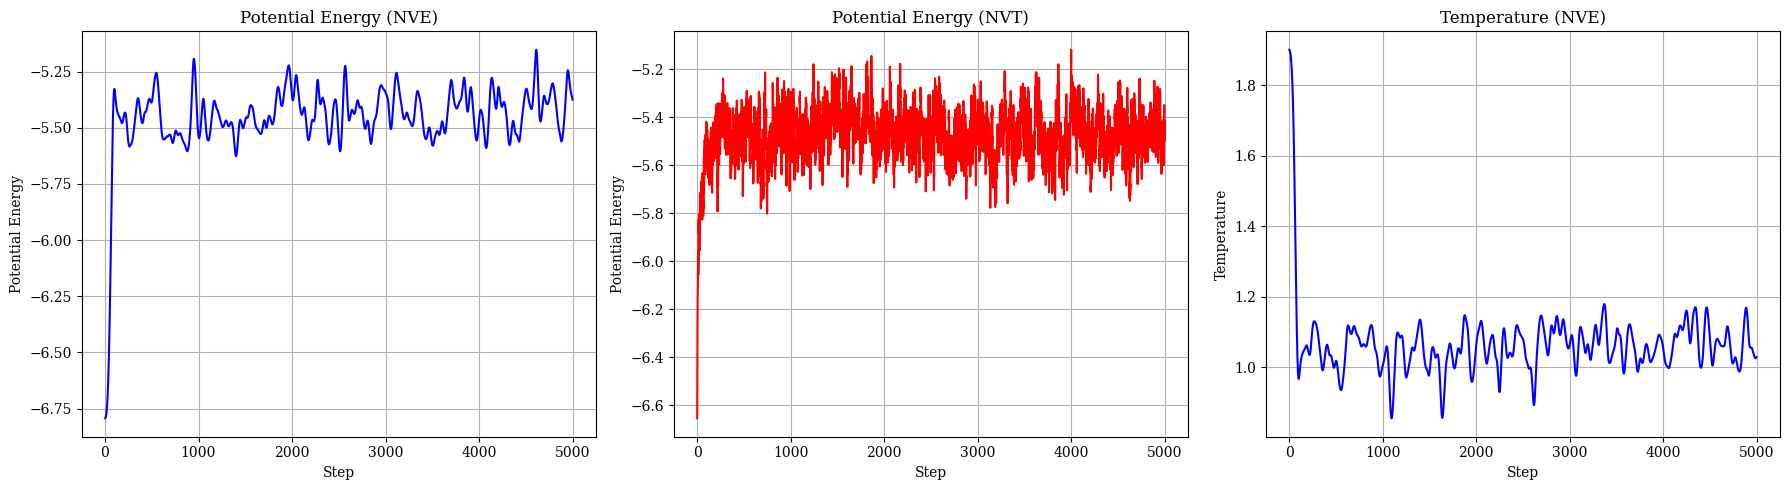

In [2]:
nve_energy_eq = pd.read_csv('NSL_SIMULATOR/OUTPUT/EQUILIBRATION/NVE/potential_energy_1.99.dat', delim_whitespace=True) 
nvt_energy_eq = pd.read_csv('NSL_SIMULATOR/OUTPUT/EQUILIBRATION/NVT/potential_energy_1.10.dat', delim_whitespace=True)
nve_temp_eq = pd.read_csv('NSL_SIMULATOR/OUTPUT/EQUILIBRATION/NVE/TEMP_EQ/temperature_1.91.dat', delim_whitespace=True)

fig, axs = plt.subplots(1, 3, figsize=(18, 5)) 

axs[0].plot(nve_energy_eq['#BLOCK:'], nve_energy_eq['ACTUAL_PE:'], color='blue', label='Potential Energy')
axs[0].set_title('Potential Energy (NVE)')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Potential Energy')
axs[0].grid()

axs[1].plot(nvt_energy_eq['#BLOCK:'], nvt_energy_eq['ACTUAL_PE:'], color='red', label='Potential Energy')
axs[1].set_title('Potential Energy (NVT)')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Potential Energy')
axs[1].grid()

axs[2].plot(nve_temp_eq['#BLOCK:'], nve_temp_eq['ACTUAL_T:'], color='blue', label='Temperature')
axs[2].set_title('Temperature (NVE)')
axs[2].set_xlabel('Step')
axs[2].set_ylabel('Temperature')
axs[2].grid()

plt.tight_layout() 
plt.show()

We can see that 5000 step is a good value for the equilibration time, since the potential energy per particle and the temperature are stable after that time. 

If we want to compare the results between NVE and NVT simulations, the mean temperature after equilibration in the NVE case should match the temperature used in the NVT simulation.  
I performed a fine tuning of the initial temperature in the NVE simulation, starting from $T = 1.91$ and increasing up to $T = 2.05$. For each value, I ran simulations of 5000 steps and evaluated the mean temperature over the last 4000 steps.


The value of t for which the average is closest to 1.1 is: 1.99
difference between optimal t and 1.1: 0.0041723439999998835


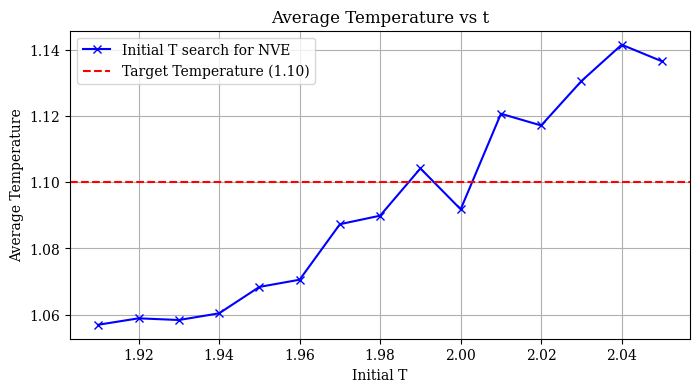

In [3]:
path = '/Users/lorenzoesposito/Desktop/università/lsn/Exercises_07/NSL_SIMULATOR/OUTPUT/EQUILIBRATION/NVE/TEMP_EQ'
t_values = np.arange(1.91, 2.06, 0.01)

t_list = []
average_t_list = []

for t in t_values:
    file_name = f'temperature_{t:.2f}.dat'
    file_path = os.path.join(path, file_name)
    if os.path.exists(file_path):
        data = pd.read_csv(file_path, delim_whitespace=True)
        average_t = data['ACTUAL_T:'][-4000:].mean()
        t_list.append(t)
        average_t_list.append(average_t)

closest_t = t_list[np.argmin(np.abs(np.array(average_t_list) - 1.1))]
index = np.argmin(np.abs(np.array(average_t_list) - 1.1))
print(f"The value of t for which the average is closest to 1.1 is: {closest_t}")
print(f"difference between optimal t and 1.1: {abs(average_t_list[index] - 1.1)}")


plt.figure(figsize=(8, 4))
plt.plot(t_list, average_t_list, marker='x', color='blue', label='Initial T search for NVE')
plt.axhline(y = 1.1, color='red', linestyle='--', label='Target Temperature (1.10)')
plt.title('Average Temperature vs t')
plt.xlabel('Initial T')
plt.ylabel('Average Temperature')
plt.grid()
plt.legend()
plt.show()

From the plot above, we can see that the temperature value that yields the closest average to $T^* = 1.1$ is $T = 1.99$, with a discard of 0.004.

Knowing the optimal starting temperature for the NVE simulation and the equilibration time, it is possible to obtain the instantaneous values of $U/N$ by performing a simulation of $M = 5 \times 10^5$ single-step blocks, setting the `RESTART` flag.

```txt
SIMULATION_TYPE        0 // 0 = NVT, 1 = NVE
RESTART                1

/* ... */

NBLOCKS                500000
NSTEPS                 1

```

### Autocorrelation function

In order to average quantities of interest, we need to know how long a run we have to average them over to get a good estimate of their expectation values. A good measure of this is the autocorrelation function. This function gives us an idea of how long we have to wait before the values of a quantity become uncorrelated (correlation time). 

The autocorrelation function for the quantity $f(t)$ is defined as:

$$\chi(t) = \frac{\langle f(t') f(t'+t) \rangle_{t'} - \langle f^2 \rangle}{\sigma_f^2}$$ 

and tipically follows an exponential decay: $$\chi(t) \simeq e^{-t/\tau}$$

where $\tau$ is the correlation time.

*Note: In the simulations, time is discretized, and therefore a discretized formula is used for the calculation.*

In [4]:

@njit
def autocorrelation_numba(m, max_lag):
    N = m.size
    
    sum_all = 0.0
    sum_sq_all = 0.0
    for i in range(N):
        sum_all += m[i]
        sum_sq_all += m[i] * m[i]
    mean_all = sum_all / N
    mean_sq_all = sum_sq_all / N
    denom = mean_sq_all - mean_all * mean_all

    cumsum = np.empty(N+1, dtype=np.float64)
    cumsum[0] = 0.0
    for i in range(N):
        cumsum[i+1] = cumsum[i] + m[i]

    ac = np.empty(max_lag + 1, dtype=np.float64)

    for t in range(max_lag + 1):
        Nt = N - t
        sum0 = cumsum[Nt]               
        sum1 = cumsum[N] - cumsum[t] 
        s_prod = 0.0
        for i in range(Nt):
            s_prod += m[i] * m[i + t]
        first = s_prod / Nt
        correction = (sum0 * sum1) / (Nt * Nt)
        ac[t] = (first - correction) / denom if denom != 0.0 else 0.0

    return ac


nve_energy_ist = pd.read_csv('NSL_SIMULATOR/OUTPUT/NVE/potential_energy_1.99.dat', delim_whitespace=True)
nvt_energy_ist = pd.read_csv('NSL_SIMULATOR/OUTPUT/NVT/potential_energy_1.10.dat', delim_whitespace=True)

max_lag = 300
series_nve = nve_energy_ist['ACTUAL_PE:'].values.astype(np.float64)
acf_values_nve = autocorrelation_numba(series_nve, max_lag)
series_nvt = nvt_energy_ist['ACTUAL_PE:'].values.astype(np.float64)
acf_values_nvt = autocorrelation_numba(series_nvt, max_lag)

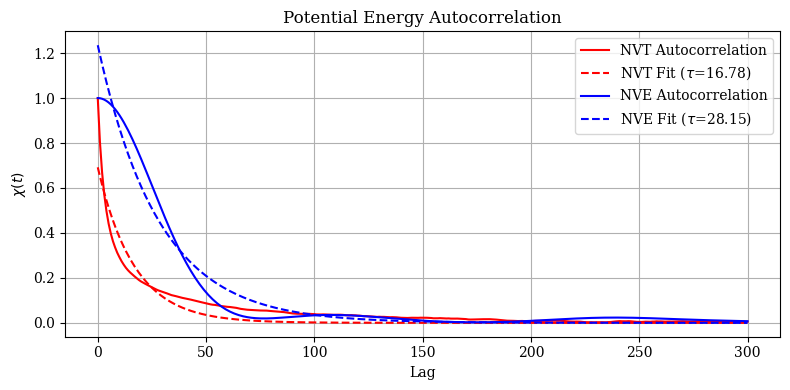

NVE Fit Parameter: tau = 28.15
NVT Fit Parameter: tau = 16.78


In [5]:
def exponential_fit(x, a, tau):
    return a * np.exp(-x / tau)

lags = np.arange(max_lag + 1)
popt_nve, pcov_nve = curve_fit(exponential_fit, lags, acf_values_nve, p0=(1, 50))
a_nve, tau_nve = popt_nve

popt_nvt, pcov_nvt = curve_fit(exponential_fit, lags, acf_values_nvt, p0=(1, 50))
a_nvt, tau_nvt = popt_nvt

plt.figure(figsize=(8, 4))
plt.plot(lags, acf_values_nvt, color='red', label='NVT Autocorrelation')
plt.plot(lags, exponential_fit(lags, *popt_nvt), color='red', linestyle='--', label=fr'NVT Fit ($\tau$={tau_nvt:.2f})')

plt.plot(lags, acf_values_nve, color='blue', label='NVE Autocorrelation')
plt.plot(lags, exponential_fit(lags, *popt_nve), color='blue', linestyle='--', label=fr'NVE Fit ($\tau$={tau_nve:.2f})')

plt.title('Potential Energy Autocorrelation')
plt.xlabel('Lag')
plt.ylabel(r'$\chi(t)$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f"NVE Fit Parameter: tau = {tau_nve:.2f}")
print(f"NVT Fit Parameter: tau = {tau_nvt:.2f}")

From the plot above, we can see that the autocorrelation function decays exponentially, suggesting that block sizes of approximately $L \sim 10^3$ should be used to obtain a reliable estimate of the mean.

We now study the statistical uncertainty of the mean of $U/N$ as a function of the block size $L$, using the instantaneous $U/N$ data obtained from the simulation.


In [6]:
M = 500000
L = 5000
N = int(M / L)

def block_average(data, L):
    N = int(len(data) / L)
    block_averages = np.empty(N, dtype=np.float64)
    for i in range(N):
        block_averages[i] = np.mean(data[i*L:(i+1)*L])
    return block_averages

def block_error(data, L):
    N = int(len(data) / L)
    block_averages = np.empty(N, dtype=np.float64)
    for i in range(N):
        block_averages[i] = np.mean(data[i*L:(i+1)*L])
    block_mean = np.mean(block_averages)
    block_var = np.var(block_averages, ddof=1)
    return np.sqrt(block_var / N)

def moving_average(data, window):
    cumsum = np.cumsum(data)
    cumsum[window:] = cumsum[window:] - cumsum[:-window]
    return cumsum[window - 1:] / window


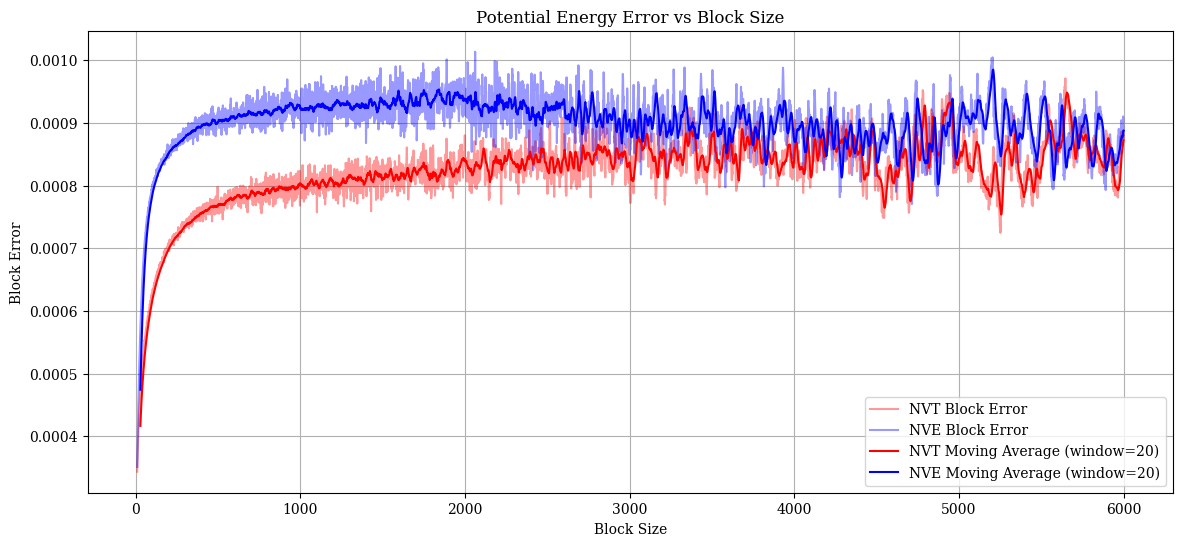

In [7]:
x = np.arange(10, 6000)
y_nvt = np.zeros(5990)
y_nve = np.zeros(5990)
error_nvt = np.zeros(5990)
error_nve = np.zeros(5990)

for i in range(10, 6000):  
    error_nvt[i-10] = block_error(nvt_energy_ist['ACTUAL_PE:'].values.astype(np.float64), i)
    error_nve[i-10] = block_error(nve_energy_ist['ACTUAL_PE:'].values.astype(np.float64), i)

window = 20
error_nvt_ma = moving_average(error_nvt, window)
error_nve_ma = moving_average(error_nve, window)
x_ma = x[window-1:] 

plt.figure(figsize=(14, 6))
plt.plot(x, error_nvt, color='red', alpha=0.4, label='NVT Block Error')
plt.plot(x, error_nve, color='blue', alpha=0.4, label='NVE Block Error')
plt.plot(x_ma, error_nvt_ma, color='red', linestyle='-', label= f'NVT Moving Average (window={window})')
plt.plot(x_ma, error_nve_ma, color='blue', linestyle='-', label= f'NVE Moving Average (window={window})')
plt.title('Potential Energy Error vs Block Size')
plt.xlabel('Block Size')
plt.ylabel('Block Error')
plt.legend()
plt.grid()
plt.show()

This plot also shows that the statistical uncertainty stabilizes for block sizes on the order of $L \sim 10^3$.

## Exercise 07.3

<span style="color:red">Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the NSL simulator code</span>: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

## Solution

### Radial distribution function

The radial distribution function, $g(r)$ is a structural quantity that gives the probability of finding a pair of atoms a distance $r$ apart, relative to the probability expected for a completely random distribution at the same density. To evaluate $g(r)$, we need to count the number of pairs of particles that are at a distance $r$ from each other. We then fill a histogram with the number of pairs of particles at each distance $r$.
The histogram is then normalized by the volume of the shell at distance $r$ and the number of particles in the system. 

### Code

I added the calculation of $g(r)$ by modifying the `System::measure()` function. While computing the distance between particles to evaluate the Lennard-Jones force, a histogram is filled in a similar way to what was done for the velocity distribution.


```c++
if(_measure_gofr){
    bin = int(dr/_bin_size); //bin index corresponding to distance r
    if(bin < _n_bins) _measurement(_index_gofr + bin) += 2.0; // factor 2 for symmetry
}
```

The normalization of the histogram is performed in the `System::averages()` function.

```c++
if (_measure_gofr) {
    for (int i = 0; i < _n_bins; i++) {
      double shell_volume = (4.0 / 3.0) * M_PI * (pow(static_cast<double>(i + 1) * _bin_size, 3) - pow(static_cast<double>(i) * _bin_size, 3)); 
      double norm = shell_volume * _rho * double(_npart); 
      _block_av(_index_gofr + i) /= norm; 
    }
}
```
Afterwards, the blocking average is computed using the standard procedures applied to the other observables. To save the final value of $g(r)$ and its statistical uncertainty, I modified the `System::finalize()` function to store the $g(r)$ values in a separate file.

```c++
void System :: finalize(string path){
  if (_measure_gofr) {
    ofstream coutf(path + "gofr_final.dat");
    coutf << "#DISTANCE:     AVE_GOFR:        ERROR:" << endl;
    for (int i = 0; i < _n_bins; i++) {
      double r = (i + 0.5) * _bin_size; 
      double sum_average = _global_av(_index_gofr + i);
      double sum_ave2 = _global_av2(_index_gofr + i);

      coutf << setw(12) << r
            << setw(12) << sum_average / (double(_nblocks)) 
            << setw(12) << this->error(sum_average, sum_ave2, _nblocks) << endl;
    }
    coutf.close();
  }
    /* ... */
}

## Exercise 07.4

By means of your upgraded NSL simulator code, equilibrate and <span style="color:red">perform MC NVT and MD NVE simulations via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ... <span style="color:red"> and compare your MC results for these quantities with those obtained via MD NVE simulations in similar thermodynamic conditions.</span>

## Solution

The simulation parameters for the Argon system are the same as those used in Exercise 7.2. Therefore, I used an equilibration time of 5000 steps. Afterwards, I restarted the simulation with 100 blocks of 3000 steps each (the optimal block size $L$ determined in Exercise 7.2), for a total of $3 \times 10^5$ steps.

In [8]:
argon_pe_nve = pd.read_csv('NSL_SIMULATOR/OUTPUT/ARGON/NVE/potential_energy_1.99.dat', delim_whitespace=True)
argon_pressure_nve = pd.read_csv('NSL_SIMULATOR/OUTPUT/ARGON/NVE/pressure_1.99.dat', delim_whitespace=True)
argon_gofr_nve = pd.read_csv('NSL_SIMULATOR/OUTPUT/ARGON/NVE/gofr_final.dat', delim_whitespace=True)

argon_pe_nvt = pd.read_csv('NSL_SIMULATOR/OUTPUT/ARGON/NVT/potential_energy_1.10.dat', delim_whitespace=True)
argon_pressure_nvt = pd.read_csv('NSL_SIMULATOR/OUTPUT/ARGON/NVT/pressure_1.10.dat', delim_whitespace=True)
argon_gofr_nvt = pd.read_csv('NSL_SIMULATOR/OUTPUT/ARGON/NVT/gofr_final.dat', delim_whitespace=True)


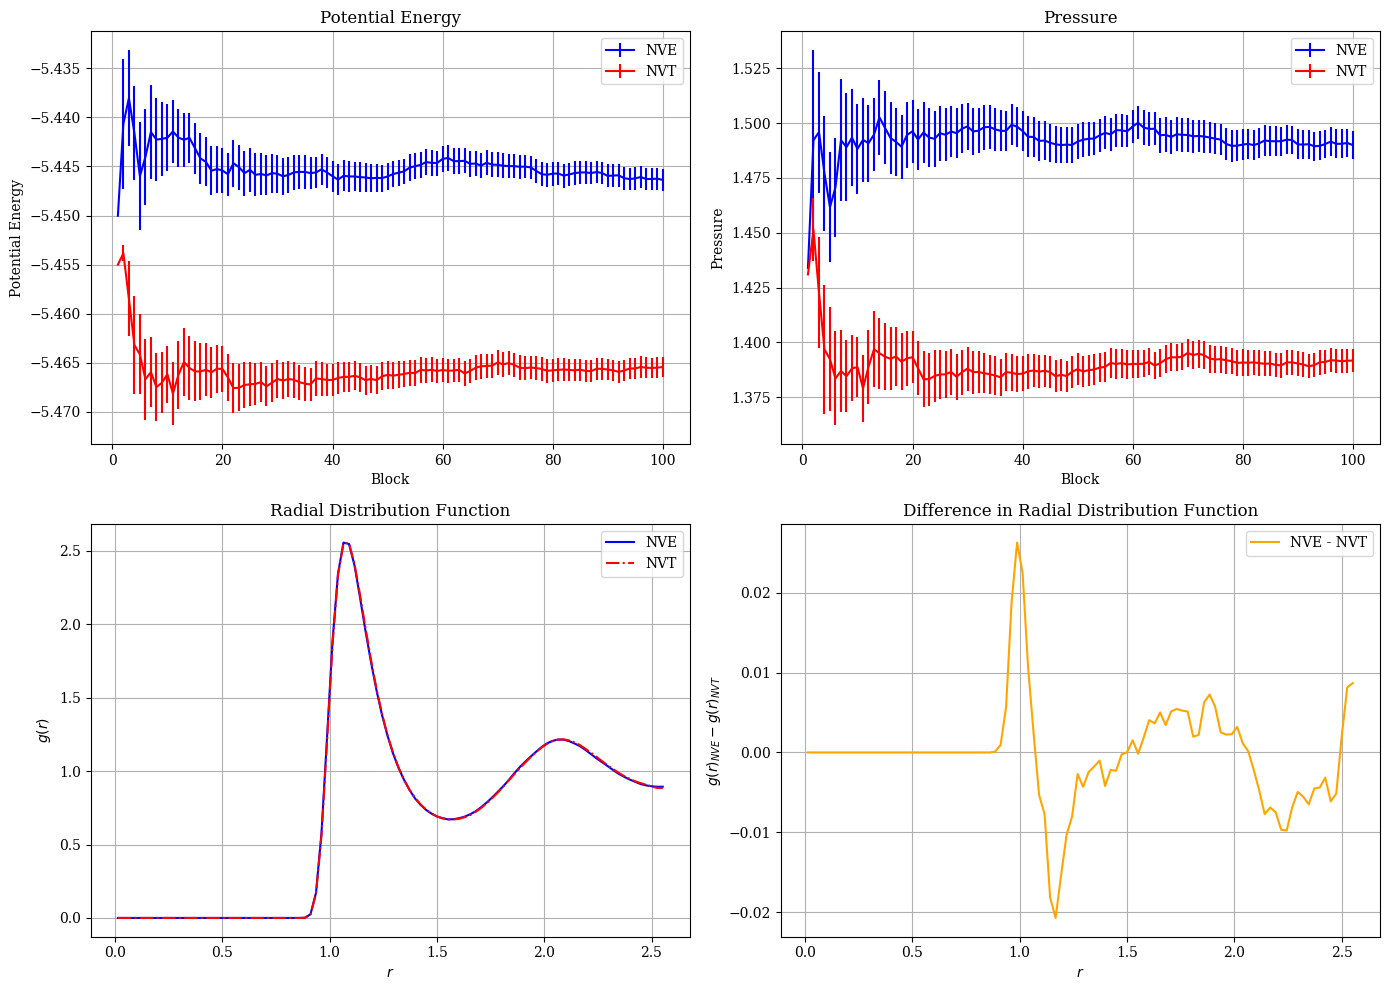

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # 2 righe, 2 colonne

# Plot 1: Potential Energy
axs[0, 0].errorbar(argon_pe_nve['#BLOCK:'], argon_pe_nve['PE_AVE:'], yerr=argon_pe_nve['ERROR:'], color='blue', label='NVE')
axs[0, 0].errorbar(argon_pe_nvt['#BLOCK:'], argon_pe_nvt['PE_AVE:'], yerr=argon_pe_nvt['ERROR:'], color='red', label='NVT')
axs[0, 0].set_title('Potential Energy')
axs[0, 0].set_xlabel('Block')
axs[0, 0].set_ylabel('Potential Energy')
axs[0, 0].grid()
axs[0, 0].legend()

# Plot 2: Pressure
axs[0, 1].errorbar(argon_pressure_nve['#BLOCK:'], argon_pressure_nve['P_AVE:'], yerr=argon_pressure_nve['ERROR:'], color='blue', label='NVE')
axs[0, 1].errorbar(argon_pressure_nvt['#BLOCK:'], argon_pressure_nvt['P_AVE:'], yerr=argon_pressure_nvt['ERROR:'], color='red', label='NVT')
axs[0, 1].set_title('Pressure')
axs[0, 1].set_xlabel('Block')
axs[0, 1].set_ylabel('Pressure')
axs[0, 1].grid()
axs[0, 1].legend()

# Plot 3: Radial Distribution Function
axs[1, 0].plot(argon_gofr_nve['#DISTANCE:'], argon_gofr_nve['AVE_GOFR:'], color='blue', label='NVE')
axs[1, 0].plot(argon_gofr_nvt['#DISTANCE:'], argon_gofr_nvt['AVE_GOFR:'], color='red', linestyle='-.', label='NVT')
axs[1, 0].set_title('Radial Distribution Function')
axs[1, 0].set_xlabel(r'$r$')
axs[1, 0].set_ylabel(r'$g(r)$')
axs[1, 0].grid()
axs[1, 0].legend()

axs[1, 1].plot(argon_gofr_nve['#DISTANCE:'], argon_gofr_nve['AVE_GOFR:'] - argon_gofr_nvt['AVE_GOFR:'], color='orange', label='NVE - NVT')
axs[1, 1].set_title('Difference in Radial Distribution Function')
axs[1, 1].set_xlabel(r'$r$')
axs[1, 1].set_ylabel(r'$g(r)_{NVE} - g(r)_{NVT}$')
axs[1, 1].grid()
axs[1, 1].legend()


plt.tight_layout()
plt.show()

We can observe that the values of $U/N$ and $P$ are slightly different between the two simulation methods. This is possibly due to the fact that the equilibrium temperature is not exactly the same in both cases. As for the radial distribution function $g(r)$, the results are very similar between the two simulation methods.
